# Advanced FEP Evaluation with YAML Configuration

This notebook demonstrates how to use YAML files to define test cases and checks for more complex evaluation scenarios. This approach is particularly useful for:

- **Team collaboration**: YAML files can be version controlled and shared
- **Large test suites**: Organize hundreds of test cases systematically
- **Configuration management**: Separate test logic from execution code
- **Reproducible evaluations**: Ensure consistent evaluation criteria across runs

We'll load test cases from YAML, run evaluations, and analyze results in detail.

NOTE: This example shows using the traditional `Check` format loaded from YAML. You can also define type-safe SchemaCheck objects directly in Python (like `ContainsCheck`, `ExactMatchCheck`, etc.) and combine them with YAML-defined test cases for maximum flexibility. The same logic can be applied to JSON files, but YAML is often more readable for complex configurations.

## Setup and Imports

In [1]:
import yaml
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from flex_evals import (
    evaluate,
    TestCase,
    Output,
    Check,
    EvaluationRunResult,
)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## Loading Test Cases from YAML

Let's examine our YAML configuration file and load the test cases.

In [2]:
# Load the YAML configuration
yaml_path = Path("test_cases.yaml")

with open(yaml_path) as f:
    config = yaml.safe_load(f)

print("YAML Configuration Structure:")
print(f"Experiment: {config['experiment']['name']}")
print(f"Description: {config['experiment']['description']}")
print(f"Number of test cases: {len(config['test_cases'])}")
print(f"Number of global checks: {len(config['global_checks'])}")

# Show the test case categories
categories = [tc['metadata']['category'] for tc in config['test_cases']]
print(f"\nTest Categories: {', '.join(set(categories))}")

YAML Configuration Structure:
Experiment: advanced_llm_evaluation
Description: Comprehensive evaluation of LLM responses across multiple domains
Number of test cases: 5
Number of global checks: 1

Test Categories: coding, word_problems, geography, mathematics, sentiment_analysis


In [3]:
# Convert YAML data to FEP objects
def load_test_cases_from_yaml(config: dict[str, object]) -> list[TestCase]:
    """Convert YAML test case definitions to FEP TestCase objects."""
    test_cases = []

    for tc_data in config['test_cases']:
        # Convert embedded checks to Check objects
        checks = []
        if 'checks' in tc_data:
            for check_data in tc_data['checks']:
                check = Check(**check_data)
                checks.append(check)

        # Create TestCase object
        test_case = TestCase(
            id=tc_data['id'],
            input=tc_data['input'],
            expected=tc_data.get('expected'),
            metadata=tc_data.get('metadata', {}),
            checks=checks if checks else None,
        )
        test_cases.append(test_case)

    return test_cases

def load_global_checks_from_yaml(config: dict[str, object]) -> list[TestCase]:
    """Convert YAML global check definitions to FEP Check objects."""
    checks = []

    for check_data in config.get('global_checks', []):
        check = Check(**check_data)
        checks.append(check)

    return checks

# Load test cases and global checks
test_cases = load_test_cases_from_yaml(config)
global_checks = load_global_checks_from_yaml(config)

print(f"Loaded {len(test_cases)} test cases")
print(f"Loaded {len(global_checks)} global checks")

# Display first test case as example
num_checks = 0
for test_case in test_cases:
    print("\nExample Test Case:")
    print(f"ID: {test_case.id}")
    print(f"Input: {test_case.input}")
    print(f"Category: {test_case.metadata['category']}")
    print(f"Number of checks: {len(test_case.checks) if test_cases[0].checks else 0}")
    num_checks += len(test_case.checks) if test_case.checks else 0

num_checks += len(global_checks) * len(test_cases)
print(f"\nTotal number of checks to be run: {num_checks}")

Loaded 5 test cases
Loaded 1 global checks

Example Test Case:
ID: qa_geography_001
Input: What is the capital of France and what is its population?
Category: geography
Number of checks: 2

Example Test Case:
ID: qa_math_001
Input: Calculate 15% of 240 and explain your reasoning
Category: mathematics
Number of checks: 3

Example Test Case:
ID: code_generation_001
Input: Write a Python function that finds the maximum element in a list
Category: coding
Number of checks: 3

Example Test Case:
ID: structured_response_001
Input: {'role': 'system', 'content': 'Analyze the sentiment of this text and provide a structured response', 'user_text': 'I absolutely love this new restaurant! The food was amazing and the service was exceptional.'}
Category: sentiment_analysis
Number of checks: 2

Example Test Case:
ID: reasoning_chain_001
Input: A train travels 120 miles in 2 hours. At this rate, how long will it take to travel 300 miles? Show your work.
Category: word_problems
Number of checks: 3

Tot

## Simulating System Outputs

In a real scenario, these outputs would come from your LLM, API, or system under test. For this demo, we'll simulate realistic responses.

In [4]:
# Simulate realistic system outputs for each test case
def create_simulated_outputs(test_cases: list[TestCase]) -> list[Output]:  # noqa: ARG001
    """Create simulated outputs that demonstrate various evaluation scenarios."""
    outputs = []

    # Geography question - good response
    outputs.append(Output(
        value="Paris is the capital of France, with a population of approximately 2.1 million people in the city proper and about 12 million in the metropolitan area.",  # noqa: E501
        metadata={"execution_time_ms": 1200, "model": "gpt-4", "tokens": 42},
    ))

    # Math question - good response with explanation
    outputs.append(Output(
        value="To calculate 15% of 240, I'll multiply 240 by 0.15. 240 × 0.15 = 36. So 15% of 240 equals 36.",  # noqa: E501, RUF001
        metadata={"execution_time_ms": 800, "model": "gpt-4", "tokens": 28},
    ))

    # Code generation - good Python function
    outputs.append(Output(
        value="""def find_max(numbers):
    \"\"\"Find the maximum element in a list.

    Args:
        numbers: List of numbers

    Returns:
        The maximum value in the list
    \"\"\"
    if not numbers:
        return None

    max_val = numbers[0]
    for num in numbers:
        if num > max_val:
            max_val = num

    return max_val""",
        metadata={"execution_time_ms": 2100, "model": "gpt-4", "tokens": 95},
    ))

    # Sentiment analysis - structured response
    outputs.append(Output(
        value="""Based on my analysis of the text \"I absolutely love this new restaurant! The food was amazing and the service was exceptional.\", here is the sentiment assessment:

**Sentiment: Positive**
**Confidence Score: 0.95**

The text contains multiple strong positive indicators:
- \"absolutely love\" - strong positive emotion
- \"amazing\" - highly positive descriptor
- \"exceptional\" - superlative positive term
- Exclamation mark indicating enthusiasm

This is clearly a very positive review with high confidence.""",  # noqa: E501
        metadata={"execution_time_ms": 1500, "model": "gpt-4", "tokens": 87},
    ))

    # Reasoning problem - shows work
    outputs.append(Output(
        value="""To solve this problem, I need to find the rate and then calculate the time for 300 miles.

Step 1: Find the rate
Rate = Distance ÷ Time = 120 miles ÷ 2 hours = 60 miles per hour

Step 2: Calculate time for 300 miles
Time = Distance ÷ Rate = 300 miles ÷ 60 mph = 5 hours

Therefore, it will take 5 hours to travel 300 miles at this rate.""",  # noqa: E501
        metadata={"execution_time_ms": 1800, "model": "gpt-4", "tokens": 76},
    ))

    return outputs

# Create simulated outputs
outputs = create_simulated_outputs(test_cases)

print(f"Created {len(outputs)} simulated outputs")
print("\nExample Output (truncated):")
print(f"Text: {outputs[0].value[:100]}...")
print(f"Metadata: {outputs[0].metadata}")

Created 5 simulated outputs

Example Output (truncated):
Text: Paris is the capital of France, with a population of approximately 2.1 million people in the city pr...
Metadata: {'execution_time_ms': 1200, 'model': 'gpt-4', 'tokens': 42}


## Running Evaluations

We'll run the evaluations. `evaluate` will run both the checks defined in the test cases and the global checks.

In [ ]:
# Run evaluation using per-test-case checks (checks embedded in test cases)

evaluation_results = await evaluate(
    test_cases=test_cases,
    outputs=outputs,
    checks=global_checks,
    metadata={
        "experiment_name": config['experiment']['name'],
        **config['experiment']['metadata'],
    },
)

print("Evaluation Results:")
print(f"Status: {evaluation_results.status}")
print(f"Completed: {evaluation_results.summary.completed_test_cases}/{evaluation_results.summary.total_test_cases}")  # noqa: E501
print(f"Execution time: {(evaluation_results.completed_at - evaluation_results.started_at).total_seconds():.3f}s")  # noqa: E501

## Detailed Results Analysis

Let's analyze the evaluation results in detail to understand how well our system performed.

In [6]:
def analyze_evaluation_results(result: EvaluationRunResult, title: str) -> pd.DataFrame:
    """Convert evaluation results to a pandas DataFrame for analysis."""
    data = []

    for test_result in result.results:
        test_case_id = test_result.execution_context.test_case.id

        # Find corresponding test case metadata
        test_case = next(tc for tc in test_cases if tc.id == test_case_id)
        category = test_case.metadata.get('category', 'unknown')
        difficulty = test_case.metadata.get('difficulty', 'unknown')

        for check_result in test_result.check_results:
            data.append({
                'test_case_id': test_case_id,
                'category': category,
                'difficulty': difficulty,
                'check_type': check_result.check_type,
                'status': check_result.status,
                'passed': check_result.results.get('passed', None),
                'evaluation_time': check_result.evaluated_at,
            })

    df = pd.DataFrame(data)  # noqa: PD901

    print(f"\n{title}")
    print("=" * len(title))

    # Overall statistics
    total_checks = len(df)
    passed_checks = df['passed'].sum() if 'passed' in df.columns else 0
    pass_rate = passed_checks / total_checks if total_checks > 0 else 0

    print(f"Total Checks: {total_checks}")
    print(f"Passed Checks: {passed_checks}")
    print(f"Pass Rate: {pass_rate:.2%}")

    # By category
    if not df.empty:
        print("\nPass Rate by Category:")
        category_stats = df.groupby('category')['passed'].agg(['count', 'sum', 'mean'])
        category_stats.columns = ['Total', 'Passed', 'Pass_Rate']
        category_stats['Pass_Rate'] = category_stats['Pass_Rate'].apply(lambda x: f"{x:.2%}")
        print(category_stats)

        print("\nPass Rate by Check Type:")
        check_stats = df.groupby('check_type')['passed'].agg(['count', 'sum', 'mean'])
        check_stats.columns = ['Total', 'Passed', 'Pass_Rate']
        check_stats['Pass_Rate'] = check_stats['Pass_Rate'].apply(lambda x: f"{x:.2%}")
        print(check_stats)

    return df

# Analyze both evaluation results
df_per_test = analyze_evaluation_results(evaluation_results, "Evaluation Analysis")


Evaluation Analysis
Total Checks: 18
Passed Checks: 14
Pass Rate: 77.78%

Pass Rate by Category:
                    Total  Passed Pass_Rate
category                                   
coding                  4       4   100.00%
geography               3       2    66.67%
mathematics             4       3    75.00%
sentiment_analysis      3       2    66.67%
word_problems           4       3    75.00%

Pass Rate by Check Type:
            Total  Passed Pass_Rate
check_type                         
contains        8       6    75.00%
regex          10       8    80.00%


## Visualization of Results

Let's create visualizations to better understand the evaluation performance.

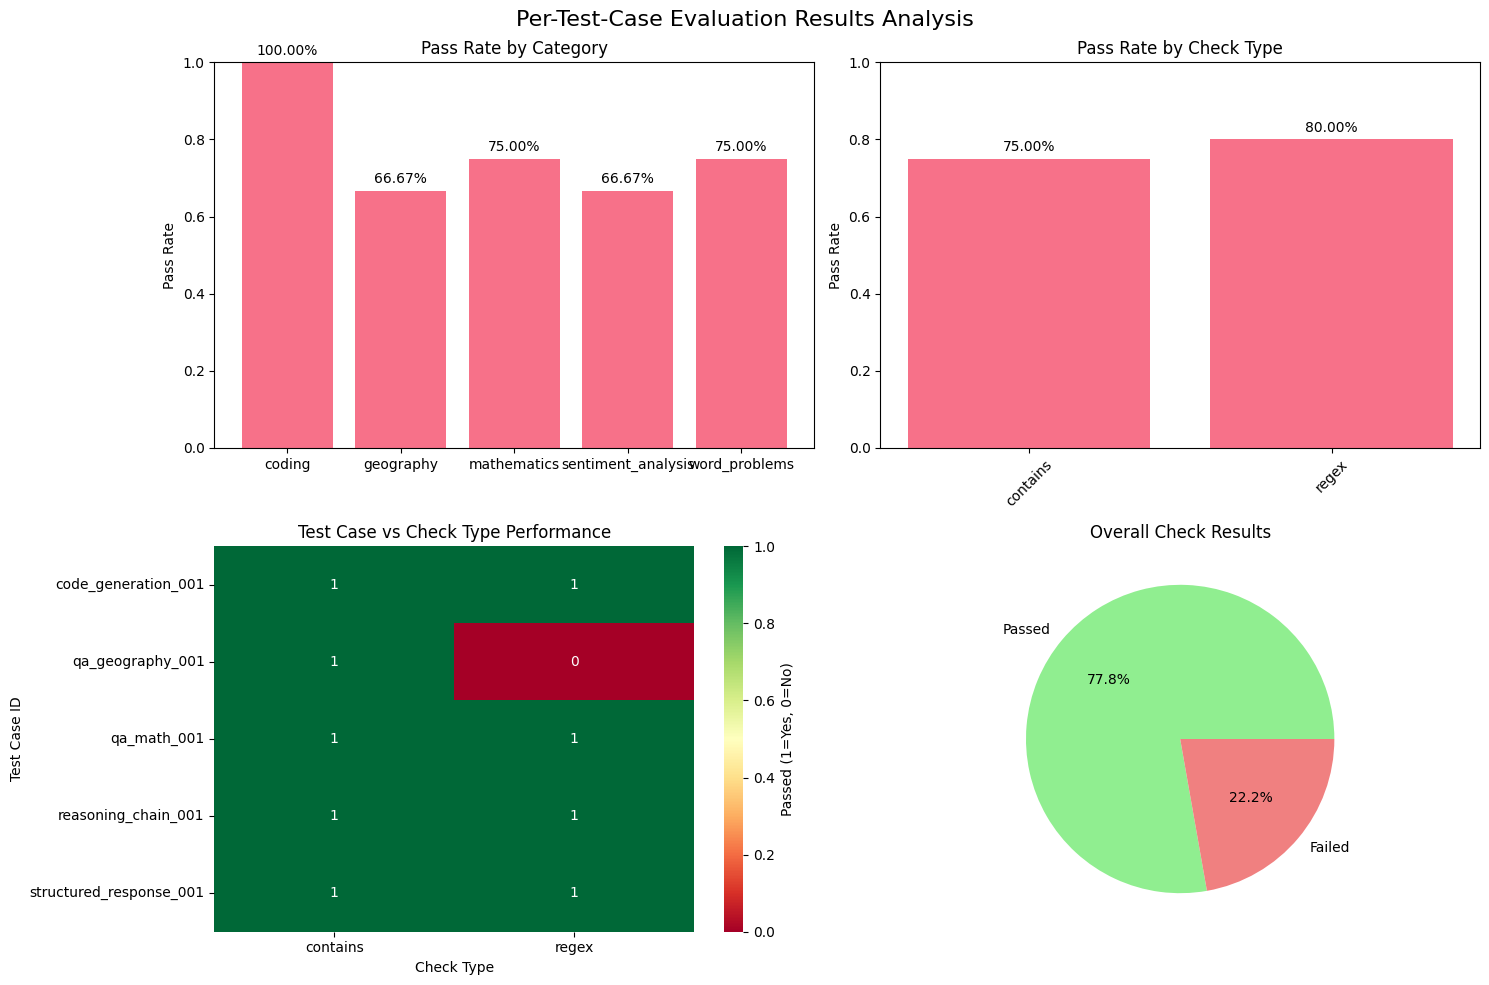

In [7]:
# Create visualizations for the per-test-case evaluation
if not df_per_test.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Per-Test-Case Evaluation Results Analysis', fontsize=16)

    # 1. Pass rate by category
    category_pass_rates = df_per_test.groupby('category')['passed'].mean()
    axes[0, 0].bar(category_pass_rates.index, category_pass_rates.values)
    axes[0, 0].set_title('Pass Rate by Category')
    axes[0, 0].set_ylabel('Pass Rate')
    axes[0, 0].set_ylim(0, 1)
    for i, v in enumerate(category_pass_rates.values):
        axes[0, 0].text(i, v + 0.02, f'{v:.2%}', ha='center')

    # 2. Pass rate by check type
    check_pass_rates = df_per_test.groupby('check_type')['passed'].mean()
    axes[0, 1].bar(check_pass_rates.index, check_pass_rates.values)
    axes[0, 1].set_title('Pass Rate by Check Type')
    axes[0, 1].set_ylabel('Pass Rate')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(check_pass_rates.values):
        axes[0, 1].text(i, v + 0.02, f'{v:.2%}', ha='center')

    # 3. Test case performance heatmap
    pivot_data = df_per_test.pivot_table(index='test_case_id', columns='check_type', values='passed', aggfunc='first')  # noqa: E501
    sns.heatmap(pivot_data, annot=True, cmap='RdYlGn', cbar_kws={'label': 'Passed (1=Yes, 0=No)'}, ax=axes[1, 0])  # noqa: E501
    axes[1, 0].set_title('Test Case vs Check Type Performance')
    axes[1, 0].set_xlabel('Check Type')
    axes[1, 0].set_ylabel('Test Case ID')

    # 4. Overall summary pie chart
    passed_count = df_per_test['passed'].sum()
    failed_count = len(df_per_test) - passed_count
    axes[1, 1].pie([passed_count, failed_count], labels=['Passed', 'Failed'], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])  # noqa: E501
    axes[1, 1].set_title('Overall Check Results')

    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization")

## Detailed Check-by-Check Analysis

Let's examine specific checks that failed to understand what improvements might be needed.

In [8]:
def detailed_check_analysis(result: EvaluationRunResult, title: str) -> None:
    """Provide detailed analysis of individual check results."""
    print(f"\n{title}")
    print("=" * len(title))

    for test_result in result.results:
        test_case = next(tc for tc in test_cases if tc.id == test_result.execution_context.test_case.id)  # noqa: E501
        print(f"\nTest Case: {test_result.execution_context.test_case.id} ({test_case.metadata.get('category', 'unknown')})")  # noqa: E501
        print(f"Input: {str(test_case.input)[:100]}{'...' if len(str(test_case.input)) > 100 else ''}")  # noqa: E501
        print(f"Overall Status: {test_result.status}")

        for i, check_result in enumerate(test_result.check_results, 1):
            passed = check_result.results.get('passed', None)
            status_icon = "✅" if passed else "❌" if passed is False else "⚠️"

            print(f"  {i}. {status_icon} {check_result.check_type}")

            # Show resolved arguments for context
            if check_result.resolved_arguments:
                for arg_name, arg_data in check_result.resolved_arguments.items():
                    value = arg_data.get('value', 'N/A')
                    jsonpath = arg_data.get('jsonpath', '')

                    # Truncate long values
                    if isinstance(value, str) and len(value) > 100:
                        value = value[:100] + "..."

                    if jsonpath:
                        print(f"     {arg_name}: {value} (from {jsonpath})")
                    else:
                        print(f"     {arg_name}: {value}")

            # Show error if any
            if check_result.error:
                print(f"     ⚠️ Error: {check_result.error.message}")

        print("-" * 80)

# Analyze per-test-case results in detail
detailed_check_analysis(evaluation_results, "Detailed Per-Test-Case Results")


Detailed Per-Test-Case Results

Test Case: qa_geography_001 (geography)
Input: What is the capital of France and what is its population?
Overall Status: completed
  1. ✅ contains
     metadata: None
     text: Paris is the capital of France, with a population of approximately 2.1 million people in the city pr... (from $.output.value)
     phrases: ['Paris']
     case_sensitive: False
     negate: False
  2. ❌ regex
     metadata: None
     text: Paris is the capital of France, with a population of approximately 2.1 million people in the city pr... (from $.output.value)
     pattern: \d{1,2}[.,]?\d{0,3}[.,]?\d{3,}
     negate: False
     flags: case_insensitive=True multiline=False dot_all=False
  3. ✅ regex
     metadata: {'type': 'global', 'description': 'Response should not contain error messages'}
     text: Paris is the capital of France, with a population of approximately 2.1 million people in the city pr... (from $.output.value)
     pattern: (error|failed|exception|invalid)
   

## Quality Threshold Analysis

Let's check if our evaluation meets the quality thresholds defined in the YAML configuration.

In [9]:
def check_quality_thresholds(result: EvaluationRunResult, config: dict[str, object]):  # noqa: ANN201
    """Check if evaluation results meet defined quality thresholds."""
    print("Quality Threshold Analysis")
    print("=" * 30)

    thresholds = config.get('quality_thresholds', {})

    # Calculate overall pass rate
    total_checks = sum(len(tr.check_results) for tr in result.results)
    passed_checks = sum(
        sum(1 for cr in tr.check_results if cr.results.get('passed', False))
        for tr in result.results
    )
    overall_pass_rate = passed_checks / total_checks if total_checks > 0 else 0

    # Check minimum pass rate
    min_pass_rate = thresholds.get('minimum_pass_rate', 0.8)
    pass_rate_met = overall_pass_rate >= min_pass_rate

    print(f"Overall Pass Rate: {overall_pass_rate:.2%}")
    print(f"Minimum Required: {min_pass_rate:.2%}")
    print(f"Threshold Met: {'✅ Yes' if pass_rate_met else '❌ No'}")

    # Check performance metrics
    warning_thresholds = thresholds.get('warning_thresholds', {})

    if 'response_time_ms' in warning_thresholds:
        max_time = warning_thresholds['response_time_ms']

        print("\nResponse Time Analysis:")
        for test_result in result.results:
            test_case_id = test_result.execution_context.test_case.id
            # Get execution time from output metadata
            output = next(o for o, tc in zip(outputs, test_cases) if tc.id == test_case_id)
            exec_time = output.metadata.get('execution_time_ms', 0)

            status = "✅" if exec_time <= max_time else "⚠️"
            print(f"  {test_case_id}: {exec_time}ms {status}")

    return {
        'overall_pass_rate': overall_pass_rate,
        'pass_rate_threshold_met': pass_rate_met,
        'total_checks': total_checks,
        'passed_checks': passed_checks,
    }

# Check quality thresholds
quality_results = check_quality_thresholds(evaluation_results, config)

Quality Threshold Analysis
Overall Pass Rate: 77.78%
Minimum Required: 80.00%
Threshold Met: ❌ No

Response Time Analysis:
  qa_geography_001: 1200ms ✅
  qa_math_001: 800ms ✅
  code_generation_001: 2100ms ✅
  structured_response_001: 1500ms ✅
  reasoning_chain_001: 1800ms ✅


## Exporting Results

Let's export our evaluation results in various formats for further analysis or reporting.

In [10]:
from dataclasses import asdict
asdict(evaluation_results)

{'evaluation_id': '8709a1ca-9fc9-46ce-b43a-067f53fdc046',
 'started_at': datetime.datetime(2025, 10, 28, 17, 57, 49, 463514, tzinfo=datetime.timezone.utc),
 'completed_at': datetime.datetime(2025, 10, 28, 17, 57, 49, 467794, tzinfo=datetime.timezone.utc),
 'status': 'completed',
 'summary': {'total_test_cases': 5,
  'completed_test_cases': 5,
  'error_test_cases': 0},
 'results': [{'status': 'completed',
   'execution_context': {'test_case': {'input': 'What is the capital of France and what is its population?',
     'id': 'qa_geography_001',
     'expected': {'city': 'Paris', 'has_population': True},
     'metadata': {'category': 'geography',
      'difficulty': 'easy',
      'source': 'knowledge_base'},
     'checks': [{'type': 'contains',
       'arguments': {'text': '$.output.value',
        'phrases': ['Paris'],
        'case_sensitive': False},
       'version': None,
       'metadata': None},
      {'type': 'regex',
       'arguments': {'text': '$.output.value',
        'pattern'

In [11]:
pd.DataFrame(evaluation_results.to_dict_list())

,evaluation_id,started_at,completed_at,evaluation_status,test_case_id,test_case_status,input_data,expected_output,actual_output,total_checks,...,output_metadata,evaluation_metadata,check_type,check_version,check_status,check_results,resolved_arguments,evaluated_at,check_results_passed,check_metadata
0,8709a1ca-9fc9-46ce-b43a-067f53fdc046,2025-10-28 17:57:49.463514+00:00,2025-10-28 17:57:49.467794+00:00,completed,qa_geography_001,completed,What is the capital of France and what is its ...,"{'city': 'Paris', 'has_population': True}","Paris is the capital of France, with a populat...",3,...,"{'execution_time_ms': 1200, 'model': 'gpt-4', ...","{'experiment_name': 'advanced_llm_evaluation',...",contains,1.0.0,completed,{'passed': True},"{'metadata': {'value': None, 'resolved_from': ...",2025-10-28 17:57:49.467092+00:00,True,NaN
1,8709a1ca-9fc9-46ce-b43a-067f53fdc046,2025-10-28 17:57:49.463514+00:00,2025-10-28 17:57:49.467794+00:00,completed,qa_geography_001,completed,What is the capital of France and what is its ...,"{'city': 'Paris', 'has_population': True}","Paris is the capital of France, with a populat...",3,...,"{'execution_time_ms': 1200, 'model': 'gpt-4', ...","{'experiment_name': 'advanced_llm_evaluation',...",regex,1.0.0,completed,{'passed': False},"{'metadata': {'value': None, 'resolved_from': ...",2025-10-28 17:57:49.467132+00:00,False,NaN
2,8709a1ca-9fc9-46ce-b43a-067f53fdc046,2025-10-28 17:57:49.463514+00:00,2025-10-28 17:57:49.467794+00:00,completed,qa_geography_001,completed,What is the capital of France and what is its ...,"{'city': 'Paris', 'has_population': True}","Paris is the capital of France, with a populat...",3,...,"{'execution_time_ms': 1200, 'model': 'gpt-4', ...","{'experiment_name': 'advanced_llm_evaluation',...",regex,1.0.0,completed,{'passed': True},"{'metadata': {'value': {'type': 'global', 'des...",2025-10-28 17:57:49.467199+00:00,True,"{'type': 'global', 'description': 'Response sh..."
3,8709a1ca-9fc9-46ce-b43a-067f53fdc046,2025-10-28 17:57:49.463514+00:00,2025-10-28 17:57:49.467794+00:00,completed,qa_math_001,completed,Calculate 15% of 240 and explain your reasoning,"{'result': 36, 'has_explanation': True}","To calculate 15% of 240, I'll multiply 240 by ...",4,...,"{'execution_time_ms': 800, 'model': 'gpt-4', '...","{'experiment_name': 'advanced_llm_evaluation',...",contains,1.0.0,completed,{'passed': True},"{'metadata': {'value': None, 'resolved_from': ...",2025-10-28 17:57:49.467258+00:00,True,NaN
4,8709a1ca-9fc9-46ce-b43a-067f53fdc046,2025-10-28 17:57:49.463514+00:00,2025-10-28 17:57:49.467794+00:00,completed,qa_math_001,completed,Calculate 15% of 240 and explain your reasoning,"{'result': 36, 'has_explanation': True}","To calculate 15% of 240, I'll multiply 240 by ...",4,...,"{'execution_time_ms': 800, 'model': 'gpt-4', '...","{'experiment_name': 'advanced_llm_evaluation',...",regex,1.0.0,completed,{'passed': True},"{'metadata': {'value': None, 'resolved_from': ...",2025-10-28 17:57:49.467275+00:00,True,NaN
5,8709a1ca-9fc9-46ce-b43a-067f53fdc046,2025-10-28 17:57:49.463514+00:00,2025-10-28 17:57:49.467794+00:00,completed,qa_math_001,completed,Calculate 15% of 240 and explain your reasoning,"{'result': 36, 'has_explanation': True}","To calculate 15% of 240, I'll multiply 240 by ...",4,...,"{'execution_time_ms': 800, 'model': 'gpt-4', '...","{'experiment_name': 'advanced_llm_evaluation',...",contains,1.0.0,completed,{'passed': False},"{'metadata': {'value': None, 'resolved_from': ...",2025-10-28 17:57:49.467334+00:00,False,NaN
6,8709a1ca-9fc9-46ce-b43a-067f53fdc046,2025-10-28 17:57:49.463514+00:00,2025-10-28 17:57:49.467794+00:00,completed,qa_math_001,completed,Calculate 15% of 240 and explain your reasoning,"{'result': 36, 'has_explanation': True}","To calculate 15% of 240, I'll multiply 240 by ...",4,...,"{'execution_time_ms': 800, 'model': 'gpt-4', '...","{'experiment_name': 'advanced_llm_evaluation',...",regex,1.0.0,completed,{'passed': True},"{'metadata': {'value': {'type': 'global', 'des..."

## Summary and Next Steps

This notebook demonstrated advanced FEP usage with YAML configuration files:

In [12]:
# Generate summary report
print("EVALUATION SUMMARY REPORT")
print("=" * 50)

print("\n📊 Overall Performance:")
print(f"   • Test Cases Evaluated: {len(test_cases)}")
print(f"   • Total Checks Executed: {quality_results['total_checks']}")
print(f"   • Overall Pass Rate: {quality_results['overall_pass_rate']:.2%}")
print(f"   • Quality Threshold Met: {'✅ Yes' if quality_results['pass_rate_threshold_met'] else '❌ No'}")  # noqa: E501

print("\n📂 Test Categories Covered:")
categories = df_per_test['category'].unique()
for category in categories:
    category_data = df_per_test[df_per_test['category'] == category]
    pass_rate = category_data['passed'].mean()
    print(f"   • {category.title()}: {pass_rate:.2%} pass rate")

print("\n🔧 Check Types Used:")
check_types = df_per_test['check_type'].unique()
for check_type in check_types:
    check_data = df_per_test[df_per_test['check_type'] == check_type]
    pass_rate = check_data['passed'].mean()
    count = len(check_data)
    print(f"   • {check_type}: {pass_rate:.2%} pass rate ({count} checks)")

print("\n💡 Key Benefits Demonstrated:")
print("   • ✅ YAML-based configuration management")
print("   • ✅ Complex JSONPath data extraction")
print("   • ✅ Multiple evaluation patterns (per-test vs global)")
print("   • ✅ Comprehensive result analysis and visualization")
print("   • ✅ Quality threshold monitoring")
print("   • ✅ Multi-format result export")

print("\n📈 Recommendations:")
if quality_results['overall_pass_rate'] < 0.9:
    print("   • Consider improving system responses for failed checks")
if quality_results['overall_pass_rate'] >= 0.95:
    print("   • Excellent performance! Consider adding more challenging test cases")
print("   • Review failed checks in detail for specific improvement areas")
print("   • Consider adding semantic similarity or LLM judge checks for nuanced evaluation")
print("   • Expand test cases to cover edge cases and error scenarios")

EVALUATION SUMMARY REPORT

📊 Overall Performance:
   • Test Cases Evaluated: 5
   • Total Checks Executed: 18
   • Overall Pass Rate: 77.78%
   • Quality Threshold Met: ❌ No

📂 Test Categories Covered:
   • Geography: 66.67% pass rate
   • Mathematics: 75.00% pass rate
   • Coding: 100.00% pass rate
   • Sentiment_Analysis: 66.67% pass rate
   • Word_Problems: 75.00% pass rate

🔧 Check Types Used:
   • contains: 75.00% pass rate (8 checks)
   • regex: 80.00% pass rate (10 checks)

💡 Key Benefits Demonstrated:
   • ✅ YAML-based configuration management
   • ✅ Complex JSONPath data extraction
   • ✅ Multiple evaluation patterns (per-test vs global)
   • ✅ Comprehensive result analysis and visualization
   • ✅ Quality threshold monitoring
   • ✅ Multi-format result export

📈 Recommendations:
   • Consider improving system responses for failed checks
   • Review failed checks in detail for specific improvement areas
   • Consider adding semantic similarity or LLM judge checks for nuanced e

## What's Next?

This advanced example showed you how to:

1. **📄 YAML Configuration**: Define test cases and checks in version-controlled YAML files
2. **🔄 Multiple Evaluation Patterns**: Use both per-test-case and global check patterns
3. **📊 Result Analysis**: Convert results to DataFrames for statistical analysis
4. **📈 Visualization**: Create charts and heatmaps to understand performance
5. **⚡ Quality Monitoring**: Check against predefined quality thresholds
6. **💾 Export & Reporting**: Save results in multiple formats for sharing

### Type-Safe Alternative

While this example uses the traditional `Check` format loaded from YAML, you can also use type-safe SchemaCheck classes for better IDE support and validation:

```python
from flex_evals import ContainsCheck, RegexCheck, ExactMatchCheck

# Type-safe checks with IDE autocompletion
checks = [
    ContainsCheck(
        text='$.output.value',
        phrases=['Paris'],
        case_sensitive=False
    ),
    RegexCheck(
        text='$.output.value',
        pattern=r'\d+',
        flags={'case_insensitive': True}
    )
]
```

You can mix and match approaches - load test cases from YAML and define checks in Python, or vice versa.

### Advanced Features to Explore:

- **Semantic Similarity Checks**: Compare meaning rather than exact text
- **LLM Judge Checks**: Use LLMs to evaluate subjective qualities  
- **Batch Processing**: Evaluate large datasets efficiently
- **CI/CD Integration**: Automate evaluations in your deployment pipeline
- **A/B Testing**: Compare different model versions systematically

The FEP framework scales from simple text comparisons to complex multi-modal evaluations, making it perfect for production LLM and AI system evaluation.